# INSTRUCTIONS TO RUN THE NOTEBOOK

1. Import libraries
2. (2.1) If you want to train the model from scratch run all the cells in the notebook
   (2.2) If you want to use the pretrained model, jump to the 'Evaluate' section. Note that if you want to use the test data provided in canvas, you also need to run the cells in 'Generate image batches' to generate the test batches. If you want to use another source of data, this code needs to be edited to use the new source.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import numpy as np
import pandas as pd
import glob
import random 
import os
import seaborn as sns
import zipfile
import itertools
import math
#visulaziation
import matplotlib.pyplot as plt
# image
from PIL import Image
import keras
#tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
# from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras import models, layers
# from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Dense#,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,Activation
import random as rn

In [ ]:
# set seeds for reproducibility
seed_value = 0
np.random.seed(seed_value)
rn.seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(seed_value)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Generate image batches

In [ ]:
# read files relevant for data loading
image_names = pd.DataFrame(pd.read_csv('drive/MyDrive/Bird_data/CUB_200_2011/images.txt', sep=" ",names=['idx', 'im_name']))
traintest = pd.DataFrame(pd.read_csv('drive/MyDrive/Bird_data/CUB_200_2011/train_test_split.txt', sep=" ",names=['idx', 'split']))
labels = pd.DataFrame(pd.read_csv('drive/MyDrive/Bird_data/CUB_200_2011/image_class_labels.txt', sep=" ",names=['idx', 'label'])) 
# merge files
image_names['split'] = traintest['split']
image_names['label'] = labels['label']
# map classes
classes = pd.DataFrame(pd.read_csv('drive/MyDrive/Bird_data/CUB_200_2011/classes.txt', sep=" ",names=['idx', 'class']))
mapeo = dict(zip(classes['idx'].values,classes['class'].values))
image_names=image_names.replace({"label": mapeo})
#divide in training and testing
image_names_train = image_names[image_names['split']==1]
image_names_test = image_names[image_names['split']==0]

In [ ]:
# create generator objects used to obtain image batches to train and test the model
datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(dataframe=image_names_train,
                directory= "drive/MyDrive/Bird_data/CUB_200_2011/images",x_col="im_name",y_col="label",
                batch_size=64,seed=42,shuffle=True,class_mode="categorical",target_size=(299,299)) # specify target size for Inception model


test_generator=datagen.flow_from_dataframe(dataframe=image_names_test,
                directory= "drive/MyDrive/Bird_data/CUB_200_2011/images",x_col="im_name",y_col="label",
                batch_size=64,seed=42,shuffle=False,class_mode="categorical",target_size=(299,299)) 

Found 5994 validated image filenames belonging to 200 classes.
Found 5792 validated image filenames belonging to 200 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="im_name". These filename(s) will be ignored.
  warnings.warn(


# Train classification layers

In [ ]:
from keras.preprocessing import image
import tensorflow_hub as hub

In [ ]:
# create model architecture using inceptionv3 feature extraction layers trained on Naturalist dataset. trainable set to false for the moment
# add dense layers to be trained in this first stage
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5", trainable=False),  
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dense(200, activation='softmax')
])
model.build([None, 299, 299, 3])  # Batch input shape.

model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
# train the network
model.fit(train_generator, epochs=10) 

Epoch 1/10
94/94 [==============================] - 635s 7s/step - loss: 3.3390 - accuracy: 0.3812 - precision: 0.8737 - recall: 0.1293
Epoch 2/10
94/94 [==============================] - 621s 7s/step - loss: 0.7703 - accuracy: 0.7995 - precision: 0.8839 - recall: 0.7102
Epoch 3/10
94/94 [==============================] - 626s 7s/step - loss: 0.5166 - accuracy: 0.8577 - precision: 0.9056 - recall: 0.8145
Epoch 4/10
94/94 [==============================] - 620s 7s/step - loss: 0.4573 - accuracy: 0.8684 - precision: 0.9114 - recall: 0.8322
Epoch 5/10
94/94 [==============================] - 619s 7s/step - loss: 0.3767 - accuracy: 0.8924 - precision: 0.9207 - recall: 0.8625
Epoch 6/10
68/94 [====================>.........] - ETA: 2:51 - loss: 0.3160 - accuracy: 0.9016 - precision: 0.9276 - recall: 0.8788

KeyboardInterrupt: 

# Tune whole network

In [ ]:
# set feature extraction layers to be trainable for this second stage
model.layers[0].trainable = True

In [ ]:
# use a small learning rate in this case
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
model.fit(train_generator, epochs=5)  

# Evaluate

In [ ]:
#load pretrained model
model2 = tf.keras.models.load_model('drive/MyDrive/Bird_data/models')

In [ ]:
model2.evaluate(test_generator)

In [ ]:
predictions = model2.predict(test_generator)
y_pred = np.argmax(predictions, axis = 1)

91/91 [==============================] - 1177s 13s/step


In [ ]:
# number_of_examples = len(test_generator.filenames)
# number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 64)) 

# test_labels = []
# for i in range(0,int(number_of_generator_calls)+1):
#     # test_labels.extend(np.array(test_generator[i][1]))
#     test_labels.extend(np.argmax(np.array(test_generator[i][1]), axis = 1))

In [ ]:
test_labels = test_generator.classes

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

In [ ]:
cm = confusion_matrix(test_labels, y_pred)

In [ ]:
np.trace(cm)

5117

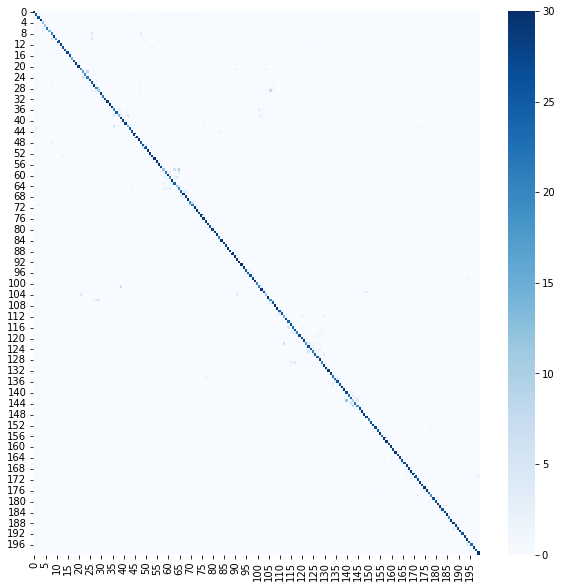

In [ ]:
import seaborn as sns 
df_cm = pd.DataFrame(cm, index = [i for i in list(range(200))],
                  columns = [i for i in list(range(200))])
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=False, cmap = 'Blues')